In [2379]:
import sklearn as sk
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2380]:
import torch
import torch.nn as nn

In [2381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#changing default cmap color
import seaborn as sns

sns.set_palette('muted')

%matplotlib inline

from tqdm.notebook import trange



In [2382]:
def g(z):
  return((1+torch.tanh(z))/2)
  #return(torch.sigmoid(z))

class LogisticRegression(nn.Module):
    def __init__(self, x, y):
      super(LogisticRegression, self).__init__()
      self.beta = torch.zeros(x.shape[1]).double().reshape(-1, 1)
      self.beta.requires_grad_()
      
    def forward(self, x):
      t = x @ self.beta
      p = torch.sigmoid(t)
      return p
      
def bce_loss(model, x, y):
  p = model(x)
  return -torch.mean(y*torch.log(p) + (1-y)*torch.log(1-p))




class LogisticRegressionTanh(nn.Module):
  def __init__(self, x, y):
    super(LogisticRegressionTanh, self).__init__()
    self.beta = torch.zeros(x.shape[1]).double().reshape(-1, 1)
    self.beta.requires_grad_()
    
  def forward(self, x):
    t = x @ self.beta
    p = g(t)
    return p
  
def tanh_loss(model, x, y):
  p = model(x)
  return -torch.mean(y*torch.log(p) + (1-y)*torch.log(1-p))

def alt_tanh_loss(model, x, y):
  p = model(x)
  return -torch.mean(y*torch.log(torch.arctanh((2*p)-1)) + (1-y)*torch.log(1-(torch.arctanh((2*p)-1))))

#for problem 3:

class LinearRegression(nn.Module):
    def __init__(self, x, y):
      super(LinearRegression, self).__init__()
      self.beta = torch.ones(x.shape[1]).double().reshape(-1, 1)
      self.beta.requires_grad_()
      
    def forward(self, x):
      return x @ self.beta

This chunk of code fits both a sigmoid and tanh activation layer model onto the data. I tried this without t = x@ self.beta and used t = x*self.beta and my loss was extremely high.

(1) Since this function is still a sigmoid of sorts (since it still tends to 0 as x approaches -$\infty$ and 1 as x approaches $\infty$) we can assume that the binary cross entropy loss function holds. We are still estimating a binary value P(T,F), which assumes a value between zero and one. No matter which "sigmoid" function we use, we can still assume that the values are either zero or one and the ernoulli distribution holds. Even though the hyperbolic tangent is {-1,1}, we can imagine that the values will fall at either -1 or 1—true or false, given a particular input. We could need to normalize the function to shift the output from {-1,1} to {0,1}.

We know that binary cross-entropy is given by:

$$
 \mathcal{L}(\beta_0, \beta_1) = -\frac{1}{n}\sum_{i = 1}^n Y_i \log \big((\sigma(\beta_x))\big) + (1 - Y_i) \log \Big(1 - (\sigma(\beta_x))\Big)
$$

where:

$$\sigma = \frac{1+\tanh(x)}{2}$$

Which yields the BCE for this particular sigmoid-ish function.

(2) I am not exactly sure since this problem is phrased oddly. While $\tanh(x)$ is zero at x=0, the function given earlier: $(\frac{\tanh(x)+1}{2})$ does not ever assume a value of zero. It approaches zero as x goes to negative infinity. This function can be used normally with the BCE loss.

(3) We compute the derivative as follows:

We start by defining $L(\beta_x)$:

$$
-\frac{1}{n} \sum_{i=1}^n Y_i \log(\frac{1+\tanh(\beta_x)}{2}+(1-Y_i)\log(1-(\frac{1+\tanh(\beta_x)}{2}))) ; \beta_x = \beta_0 + \beta_1 X_i
$$

With a little bit of differentiation, we arrive at:

$$
\frac{\partial \mathcal{L}}{\partial \beta_x} = -\frac{1}{n} \sum_{i=1}^n Y_i (\frac{1-(\tanh(\beta_x))^2}{1+\tanh(\beta_x)})+(1-Y_i)(\frac{(\tanh(\beta_x))^2-1}{1-(\frac{1+\tanh(\beta_x)}{2})})
$$


(4) Now to find the second derivative to check curvature:

$$
\frac{\partial \mathcal{L}^2}{\partial ^2 \beta_x} = -\frac{1}{n} \sum_{i=1}^n 2\text{ sech}^2(\beta_x) + Y_i( \text{sech}^2(\beta_x))
$$

Since this expression is negative, it is not convex.

In [2383]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

cancer = datasets.load_breast_cancer(as_frame=True)
X, y = cancer.data, cancer.target

print(X.shape)
#

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(x_train.shape)
x_train = torch.tensor(np.array(x_train))
y_train = torch.tensor(np.array(y_train)).reshape(-1, 1)
x_test = torch.tensor(np.array(x_test))
y_test = torch.tensor(np.array(y_test)).reshape(-1, 1)

print(x_train.shape)

x_mean = torch.mean(x_train, axis = 0)
x_sd = torch.std(x_train, axis = 0)

x_train = (x_train - x_mean[None,:]) / x_sd[None,:]
x_test = (x_test - x_mean[None,:]) / x_sd[None,:]


(569, 30)
(426, 30)
torch.Size([426, 30])


The above chunk of code loads the data, splits it in a controlled way (since we set a state), then standardizes it. We also convert the data into numpy tensors.  

In [2384]:
lr = LogisticRegressionTanh(x_train, y_train)

loss_trace = np.zeros(3000)

#I've hand-fine-tuned the learning rate to get the best loss

for i in trange(3000):
  loss = tanh_loss(lr, x_train, y_train)

  loss_trace[i] = loss

  loss.backward()
  lr.beta.data = lr.beta.data - 1e-3 * lr.beta.grad
  
  lr.beta.grad.zero_()

  0%|          | 0/3000 [00:00<?, ?it/s]

**1**. The above chunk takes the tanh activation layer and performs backprop to optimize the parameters.

In [2385]:
tr = LogisticRegression(x_train, y_train)

loss_trace_line = np.zeros(15500)

for i in trange(15500):

  lo = bce_loss(tr, x_train, y_train)
  loss_trace_line[i] = lo
  lo.backward()

  tr.beta.data = tr.beta.data - 1e-3 * tr.beta.grad
  tr.beta.grad.zero_()

  0%|          | 0/15500 [00:00<?, ?it/s]

**2**. The above chunk takes the sigmoid activation layer and performs backprop to optimize the parameters.

array([0.69314718, 0.68540383, 0.67785419, ..., 0.09835295, 0.09834275,
       0.09833255])

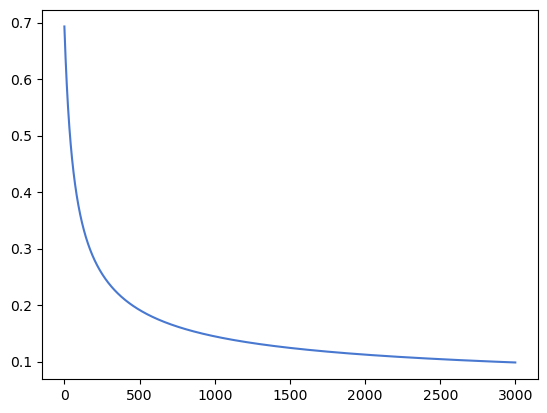

In [2386]:
#hyperbolic tangent
plt.plot(loss_trace)

loss_trace

This is a plot of the tanh loss parametrized with iterations.

array([0.69314718, 0.69120214, 0.68926934, ..., 0.09103716, 0.09103545,
       0.09103373])

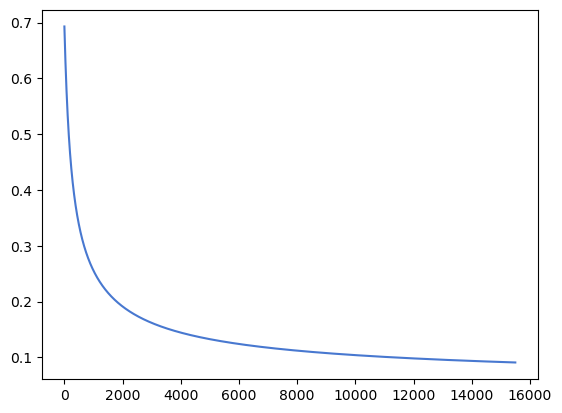

In [2387]:
#sigmoid
plt.plot(loss_trace_line)

loss_trace_line

This is a plot of the sigmoid loss parametrized with iterations. The hyperbolic tangent was able to achieve a better loss a lot faster ans with a lower learning rate, avoiding imploding gradients that the sigmoid funtion would have.

torch.Size([426])
torch.Size([426])


torch.Size([426, 1])

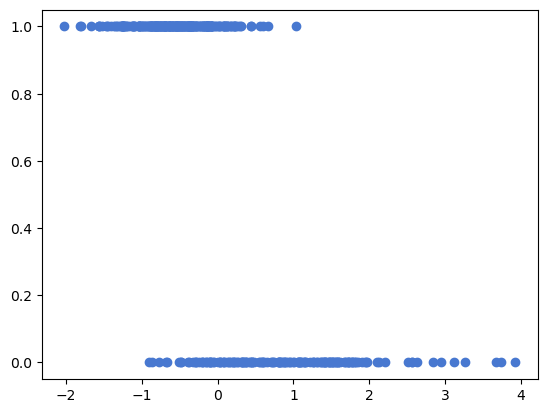

In [2388]:
plt.scatter(x_train[:,0], y_train)
print(torch.Tensor.size(x_train[:,0]))
print(torch.Tensor.size(y_train[:,0]))

torch.Tensor.size(lr(x_train).detach())

torch.Size([426, 30])
torch.Size([426, 1])


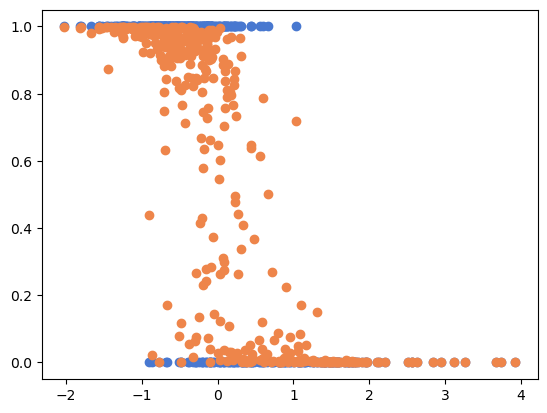

In [2389]:
#Tanh
p_hat_train = lr(x_train)
y_hat_train = (p_hat_train > 0.5).int()
print(torch.Tensor.size(x_train))
print(torch.Tensor.size(p_hat_train.detach()))


plt.scatter(x_train[:,0], y_train, label = 'Obs')
plt.scatter(x_train[:,0], p_hat_train.detach()[:,0], label = 'pred prob')

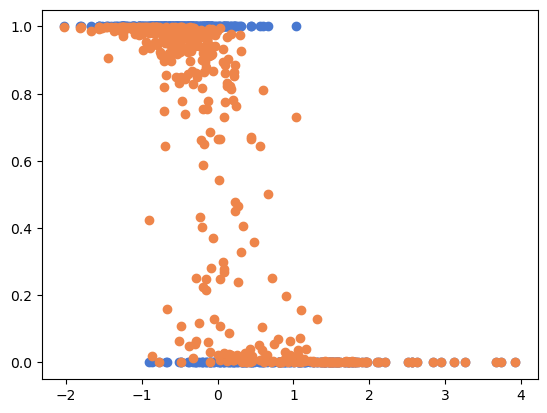

In [2390]:
#sigmoid
p_hat_train_l = tr(x_train)
y_hat_train_l = (p_hat_train > 0.5).int()
#print(torch.Tensor.size(x_train))
#print(torch.Tensor.size(p_hat_train.detach()))


plt.scatter(x_train[:,0], y_train, label = 'Obs')
plt.scatter(x_train[:,0], p_hat_train_l.detach()[:,0], label = 'pred prob')

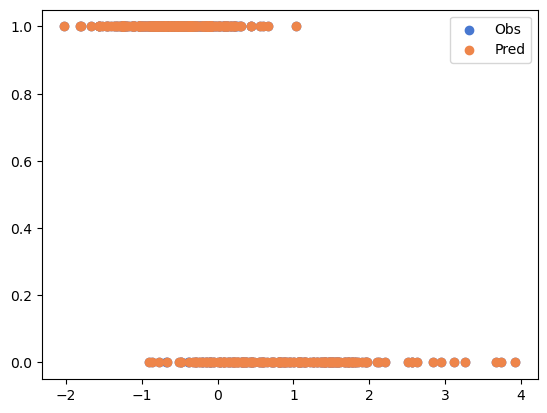

In [2391]:
#Tanh
plt.scatter(x_train[:,0], y_train, label = 'Obs')
plt.scatter(x_train[:,0], y_hat_train[:,0], label = 'Pred')
plt.legend()

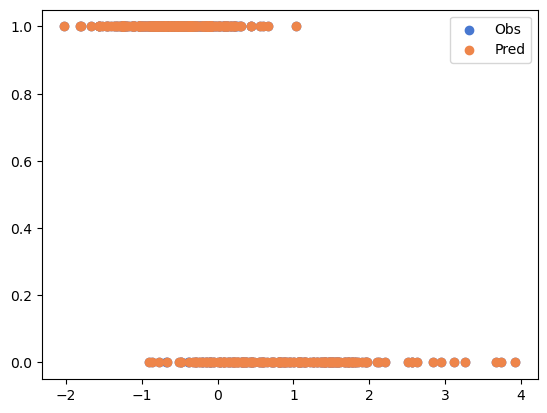

In [2392]:
plt.scatter(x_train[:,0], y_train, label = 'Obs')
plt.scatter(x_train[:,0], y_hat_train_l[:,0], label = 'Pred')
plt.legend()

Okay, now we need to analyze the actual fit with the testing data:

torch.Size([143, 30])
torch.Size([143, 1])


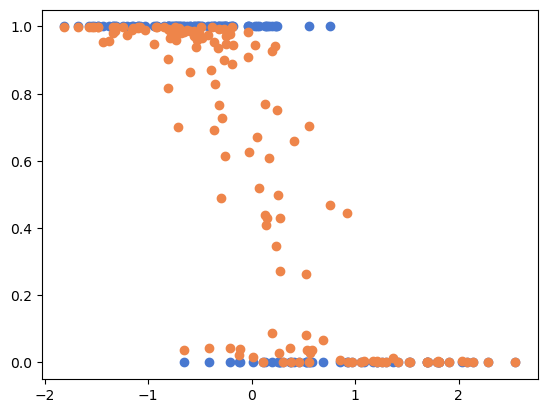

In [2393]:
#Tanh testing
p_hat = lr(x_test)
y_hat = (p_hat > 0.5).int()
print(torch.Tensor.size(x_test))
print(torch.Tensor.size(p_hat.detach()))


plt.scatter(x_test[:,0], y_test, label = 'Obs')
plt.scatter(x_test[:,0], p_hat.detach()[:,0], label = 'pred prob')

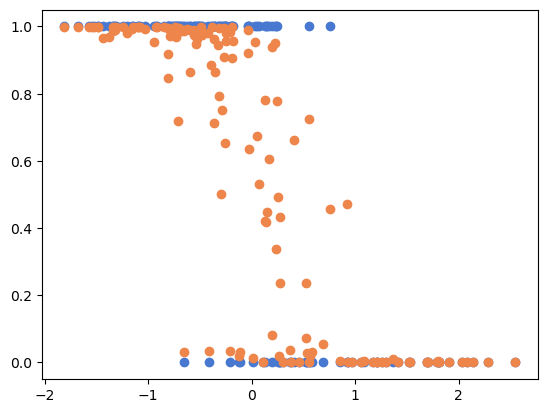

In [2394]:
#Sigmoid testing data
p_hat_l = tr(x_test)
y_hat_l = (p_hat_l > 0.5).int()
#print(torch.Tensor.size(x_test))
#print(torch.Tensor.size(p_hat.detach()))


plt.scatter(x_test[:,0], y_test, label = 'Obs')
plt.scatter(x_test[:,0], p_hat_l.detach()[:,0], label = 'pred prob')

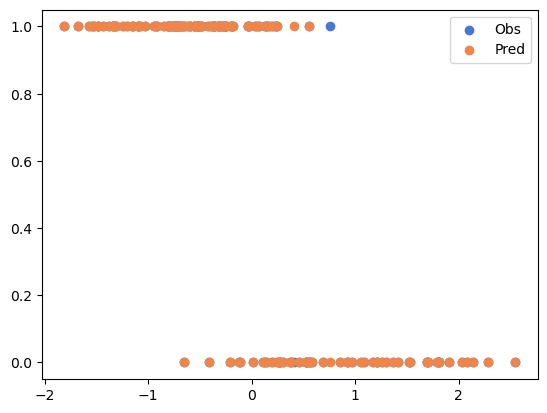

In [2395]:
plt.scatter(x_test[:,0], y_test, label = 'Obs')
plt.scatter(x_test[:,0], y_hat_l[:,0], label = 'Pred')
plt.legend()

In [2396]:
#tanh test accuracy
correct = 0
for i in zip(y_test.flatten(), y_hat[:,0].flatten()):
    if(int(i[0])==int(i[1])):
        correct += 1

print(correct/len(y_test))

0.958041958041958


95 percent accuracy on test data for tanh.

In [2397]:
#tanh training accuracy
correct = 0
for i in zip(y_train.flatten(), y_hat_train[:,0].flatten()):
    if(int(i[0])==int(i[1])):
        correct += 1

print(correct/len(y_train))

0.9812206572769953


Above is training accuracy for tanh.

In [2398]:
#sigmoid test accuracy
correct = 0
for i in zip(y_test.flatten(), y_hat_l[:,0].flatten()):
    if(int(i[0])==int(i[1])):
        correct += 1

print(correct/len(y_test))

0.965034965034965


0.993 testing accuracy for sigmoid.

torch.Size([143])
torch.Size([143])


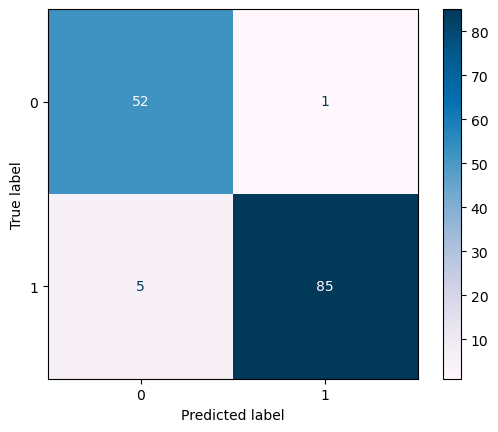

In [2399]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(y_test.flatten().size())
print(y_hat[:,0].size())


cm = confusion_matrix(y_test.flatten(), y_hat[:,0])
ConfusionMatrixDisplay(cm).plot(cmap="PuBu")

Now let's compare our model's results to results from random selection(random guess):

In [2400]:
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(X, y, test_size=0.25, random_state=0)

In [2401]:
from sklearn.dummy import DummyClassifier

dumb = DummyClassifier(strategy="stratified")
dumb.fit(x_train_a, y_train_a)

dumb_hat = dumb.predict(x_train_a)


In [2402]:
dumb_unif = DummyClassifier(strategy="stratified")
dumb_unif.fit(x_train_a, y_train_a)

dumb_hat_unif = dumb.predict(x_test_a)


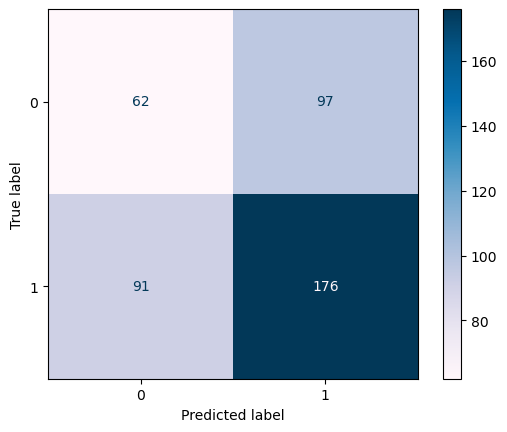

In [2403]:
cm = confusion_matrix(y_train_a, dumb_hat)
ConfusionMatrixDisplay(cm).plot(cmap="PuBu")

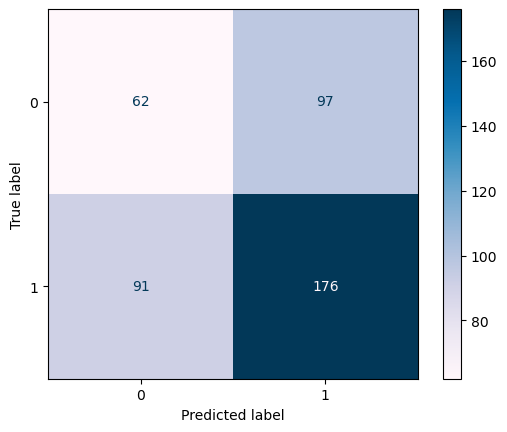

In [2404]:
cm = confusion_matrix(y_train_a, dumb_hat)
ConfusionMatrixDisplay(cm).plot(cmap="PuBu")

In [2405]:
correct = 0
is_zero = 0
for i in zip(y_test.flatten(), dumb_hat.flatten()):
    if(int(i[1]) == 0):
        is_zero += 1
    if(int(i[0])==int(i[1])):
        correct += 1
print(correct/len(y_test))
print(is_zero)

0.5174825174825175
50


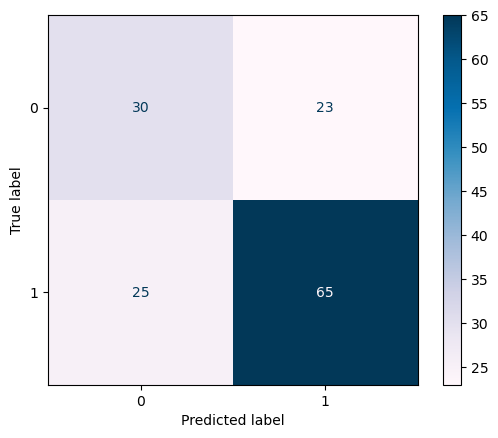

In [2406]:
cm = confusion_matrix(y_test.flatten(), dumb_hat_unif)
ConfusionMatrixDisplay(cm).plot(cmap="PuBu")

In [2407]:
correct = 0
is_zero = 0
for i in zip(y_test.flatten(), dumb_hat_unif.flatten()):
    if(int(i[1]) == 0):
        is_zero += 1
    if(int(i[0])==int(i[1])):
        correct += 1
print(correct/len(y_test))
print(is_zero)

0.6643356643356644
55


So if we just randomly guessed at prediction, the accuracy is only around 50. This shows that our model produces results more accurate than randomly guessing at an answer.

143
143


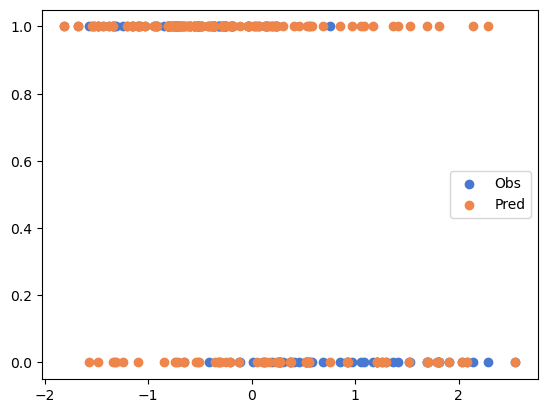

In [2408]:

plt.scatter(x_test[:,0], y_test, label = 'Obs')
plt.scatter(x_test[:,0],dumb_hat_unif, label = 'Pred')
print(len(dumb_hat_unif))
print(len(x_test[:,0]))
plt.legend()

The 53 percent guessing accuracy vs 95 percent model accuracy for the tanh model shows that we are a lot better off using the model to predict cancer versus randomly guessing.

**3**. The accuracy for the sigmoid function model is roughly 1.03 multiplied by the value of the hyperbolic tangent function. I am not sure if this is due to overfitting of the model, though. Since we used no validation layer, this is entirely possible and further analysis needs to be done. I would not consider this conclusive.

In [2409]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat

--2023-03-06 18:52:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250119 (244K) [application/x-httpd-php]
Saving to: 'pop_failures.dat.33'

pop_failures.dat.33 100%[===================>] 244.26K  1.23MB/s    in 0.2s    

2023-03-06 18:52:28 (1.23 MB/s) - 'pop_failures.dat.33' saved [250119/250119]



In [2410]:
import pandas as pd
climate = pd.read_csv('pop_failures.dat', sep="\s+")

In [2411]:
print(climate.columns)

Index(['Study', 'Run', 'vconst_corr', 'vconst_2', 'vconst_3', 'vconst_4',
       'vconst_5', 'vconst_7', 'ah_corr', 'ah_bolus', 'slm_corr',
       'efficiency_factor', 'tidal_mix_max', 'vertical_decay_scale',
       'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_ban', 'bckgrnd_vdc_eq',
       'bckgrnd_vdc_psim', 'Prandtl', 'outcome'],
      dtype='object')


In [2412]:
print(climate.head())
for i in range(climate.shape[0]):
    climate["outcome"][i] = int(not(climate["outcome"][i]))
    #some good ole' bit flippin' in linear time
for i in climate["outcome"]:
    print(i)

   Study  Run  vconst_corr  vconst_2  vconst_3  vconst_4  vconst_5  vconst_7  \
0      1    1     0.859036  0.927825  0.252866  0.298838  0.170521  0.735936   
1      1    2     0.606041  0.457728  0.359448  0.306957  0.843331  0.934851   
2      1    3     0.997600  0.373238  0.517399  0.504993  0.618903  0.605571   
3      1    4     0.783408  0.104055  0.197533  0.421837  0.742056  0.490828   
4      1    5     0.406250  0.513199  0.061812  0.635837  0.844798  0.441502   

    ah_corr  ah_bolus  ...  efficiency_factor  tidal_mix_max  \
0  0.428325  0.567947  ...           0.245675       0.104226   
1  0.444572  0.828015  ...           0.616870       0.975786   
2  0.746225  0.195928  ...           0.679355       0.803413   
3  0.005525  0.392123  ...           0.471463       0.597879   
4  0.191926  0.487546  ...           0.551543       0.743877   

   vertical_decay_scale  convect_corr  bckgrnd_vdc1  bckgrnd_vdc_ban  \
0              0.869091      0.997518      0.448620         0.

/var/folders/kr/vzj_zzlj3h7d3zf49gsxx89c0000gn/T/ipykernel_19017/277552001.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate["outcome"][i] = int(not(climate["outcome"][i]))


In [2413]:
u = climate["outcome"]
p = climate.drop(["Study","Run"],axis = 1)

print(u)
print(p)

0      1
1      0
2      0
3      0
4      0
      ..
535    0
536    1
537    0
538    0
539    0
Name: outcome, Length: 540, dtype: int64
     vconst_corr  vconst_2  vconst_3  vconst_4  vconst_5  vconst_7   ah_corr  \
0       0.859036  0.927825  0.252866  0.298838  0.170521  0.735936  0.428325   
1       0.606041  0.457728  0.359448  0.306957  0.843331  0.934851  0.444572   
2       0.997600  0.373238  0.517399  0.504993  0.618903  0.605571  0.746225   
3       0.783408  0.104055  0.197533  0.421837  0.742056  0.490828  0.005525   
4       0.406250  0.513199  0.061812  0.635837  0.844798  0.441502  0.191926   
..           ...       ...       ...       ...       ...       ...       ...   
535     0.657136  0.489375  0.133713  0.411950  0.087780  0.356289  0.480204   
536     0.915894  0.842720  0.518947  0.090622  0.336981  0.893576  0.978703   
537     0.478600  0.941185  0.769245  0.950776  0.189406  0.112743  0.745645   
538     0.007793  0.779287  0.867468  0.704820  0.983282  0.

In [2414]:
#u = torch.tensor(np.array(u))
#p = torch.tensor(np.array(p))

print(p.shape)

(540, 19)


In [2415]:
x_train, x_remain, y_train, y_remain = train_test_split(p, u, test_size=0.6, random_state=0)
#purposely using a small training set



x_train = torch.tensor(np.array(x_train))
y_train = torch.tensor(np.array(y_train)).reshape(-1, 1)

x_test, x_val, y_test, y_val = train_test_split(x_remain, y_remain, test_size=0.5, random_state=0)

x_test = torch.tensor(np.array(x_test))
y_test = torch.tensor(np.array(y_test)).reshape(-1, 1)

x_val = torch.tensor(np.array(x_val))
y_val = torch.tensor(np.array(y_val)).reshape(-1, 1)



### scale inputs
print(x_train)
print(x_test.shape)


tensor([[0.2802, 0.6160, 0.9032,  ..., 0.9715, 0.2346, 0.0000],
        [0.3176, 0.7440, 0.6491,  ..., 0.8530, 0.4607, 0.0000],
        [0.2664, 0.0828, 0.4840,  ..., 0.4760, 0.8804, 0.0000],
        ...,
        [0.6556, 0.4139, 0.8053,  ..., 0.0073, 0.4200, 0.0000],
        [0.4575, 0.0609, 0.4377,  ..., 0.0338, 0.3553, 0.0000],
        [0.8224, 0.9297, 0.6364,  ..., 0.6410, 0.0461, 0.0000]],
       dtype=torch.float64)
torch.Size([162, 19])


In [2416]:
import torch
import torch.nn as nn

class LogisticRegression(nn.Module):
  def __init__(self, x, y):
    super(LogisticRegression, self).__init__()
    self.beta = torch.zeros(x.shape[1]).double().reshape(-1, 1)
    self.beta.requires_grad_()

  def forward(self, x):
    t = x @ self.beta
    p = torch.sigmoid(t)
    return p
      
def bce_loss(model, x, y):
  p = model(x)
  return -torch.mean(y*torch.log(p) + (1-y)*torch.log(1-p))

In [2417]:
lr = LogisticRegression(x_train, y_train)

loss_trace = np.zeros(1400)

#I've hand-fine-tuned the learning rate to get the best loss

for i in trange(1400):
  loss = bce_loss(lr, x_train, y_train)

  loss_trace[i] = loss

  loss.backward()
  lr.beta.data = lr.beta.data - 2.7e-2 * lr.beta.grad
  
  lr.beta.grad.zero_()

  0%|          | 0/1400 [00:00<?, ?it/s]

array([0.69314718, 0.67325041, 0.6545545 , ..., 0.12091055, 0.12084405,
       0.12077761])

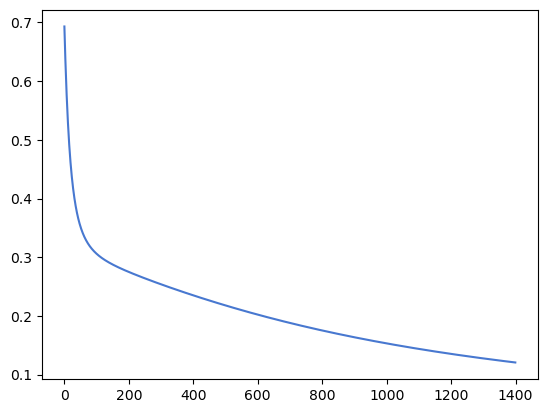

In [2418]:
# plot loss traces
plt.plot(loss_trace)

loss_trace

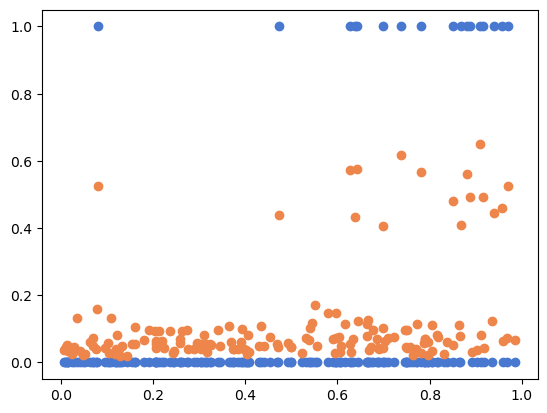

In [2419]:
p_hat = lr(x_test)
y_hat = (p_hat > 0.5).int()

p_hat_train = lr(x_train)
y_hat_train = (p_hat > 0.5).int()


plt.scatter(x_test[:,0], y_test, label = 'Obs')
plt.scatter(x_test[:,0], p_hat.detach()[:,0], label = 'pred prob')

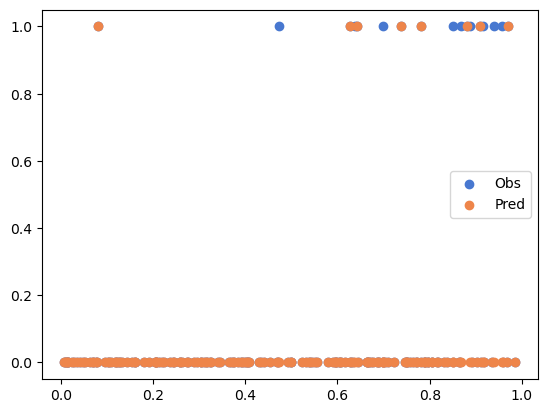

In [2420]:
plt.scatter(x_test[:,0], y_test, label = 'Obs')
plt.scatter(x_test[:,0],y_hat, label = 'Pred')
plt.legend()

In [2421]:
# test accuracy
correct = 0
is_zero = 0
for i in zip(y_test.flatten(), y_hat.flatten()):
    if(int(i[1]) == 0):
        is_zero += 1
    if(int(i[0])==int(i[1])):
        correct += 1
print(correct/len(y_test))
print(is_zero)
print(len(y_test))

0.9444444444444444
154
162


In [2422]:
# train accuracy
correct = 0
is_zero = 0
for i in zip(y_train.flatten(), y_hat_train.flatten()):
    if(int(i[1]) == 0):
        is_zero += 1
    if(int(i[0])==int(i[1])):
        correct += 1
print(correct/len(y_test))
print(is_zero)
print(len(y_test))

0.8765432098765432
154
162


(1) The test accuracy is pretty good.

(2) Sensitivity is the true positive rate, and specificity is the true negative rate. We can verbalize this by imagining TSA screening for weapons: true negative in this case would be good, true positive woula also be good, since we would expect weapons to be detected. False positive would be bad and embarrassing for a traveler, but a false negative would be the worst case scenario. More formally, sensitivity is true positive/all positives and specificity is true negatives/all negatives.

(3) will crash when actually crash = true positive/all positives, so this is the sensitivity. Our model does a poor job at this.

specificity =  1.0
sensitivity =  0.47058823529411764


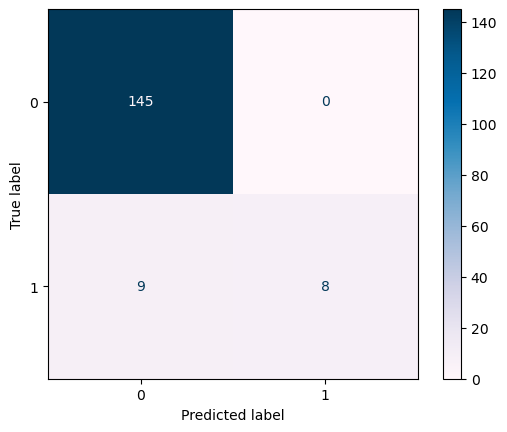

In [2423]:
# sensitivity and specificity\

cm = confusion_matrix(y_test.flatten(), y_hat.flatten())
ConfusionMatrixDisplay(cm).plot(cmap="PuBu")

print("specificity = ", cm[0,0]/(cm[0,0]+cm[0,1]))
print("sensitivity = ", cm[1,1]/(cm[1,0]+cm[1,1]))


<Figure size 640x480 with 0 Axes>

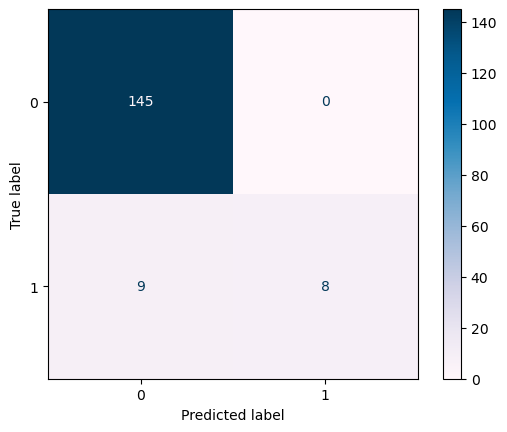

In [2424]:
# code goes here
plt.set_cmap('PuBu')
ConfusionMatrixDisplay(cm).plot(cmap="PuBu")

We have very few instances of actual positives in the dataset, so I would say that this dataset is imbalanced. We can see that there are very few examples of failures compared to successes, so our model will be better at identifying cases of the majority class. We can solve this by weighting the loss function to better differentiate the classes:

In [2425]:
def weighted_bce_loss(model, x, y, w1, w0):
  p = model(x)
  return -torch.mean(w1 * y*torch.log(p) + w0 * (1-y)*torch.log(1-p))

In [2426]:
p1 = y_train.shape[0] / torch.sum(y_train)
p0 = y_train.shape[0] / torch.sum(1 - y_train)

print(torch.sum(y_test))
print(torch.sum(1 - y_test))
#verifying that this yields the information we're looking for.
#Yields the same row sums from the confusion matrix.

#A cool application of Bayes' Law:

w1 = p1 / (p1 + p0)
w0 = p0 / (p1 + p0)

print(w1)
print(w0)

tensor(17)
tensor(145)
tensor(0.9120)
tensor(0.0880)


In [2427]:
lr = LogisticRegression(x_train, y_train)

#adjusted iterations until the model didn't seem overfit

loss_trace = np.zeros(500)

#I've hand-fine-tuned the learning rate to get the best loss

for i in trange(500):
  loss = weighted_bce_loss(lr, x_train, y_train, w1, w0)

  loss_trace[i] = loss

  loss.backward()
  lr.beta.data = lr.beta.data - 2.7e-2 * lr.beta.grad
  
  lr.beta.grad.zero_()

  0%|          | 0/500 [00:00<?, ?it/s]

array([0.11121612, 0.11115645, 0.11109691, 0.11103751, 0.11097823,
       0.11091909, 0.11086007, 0.11080119, 0.11074243, 0.11068379,
       0.11062528, 0.1105669 , 0.11050863, 0.11045049, 0.11039247,
       0.11033458, 0.11027679, 0.11021913, 0.11016159, 0.11010416,
       0.11004684, 0.10998964, 0.10993255, 0.10987558, 0.10981871,
       0.10976196, 0.10970531, 0.10964878, 0.10959235, 0.10953603,
       0.10947982, 0.10942371, 0.1093677 , 0.1093118 , 0.109256  ,
       0.10920031, 0.10914471, 0.10908922, 0.10903382, 0.10897853,
       0.10892333, 0.10886823, 0.10881323, 0.10875832, 0.10870351,
       0.10864879, 0.10859417, 0.10853964, 0.1084852 , 0.10843085,
       0.1083766 , 0.10832243, 0.10826836, 0.10821437, 0.10816047,
       0.10810666, 0.10805294, 0.1079993 , 0.10794575, 0.10789229,
       0.1078389 , 0.10778561, 0.10773239, 0.10767926, 0.10762622,
       0.10757325, 0.10752036, 0.10746756, 0.10741483, 0.10736219,
       0.10730962, 0.10725713, 0.10720472, 0.10715239, 0.10710

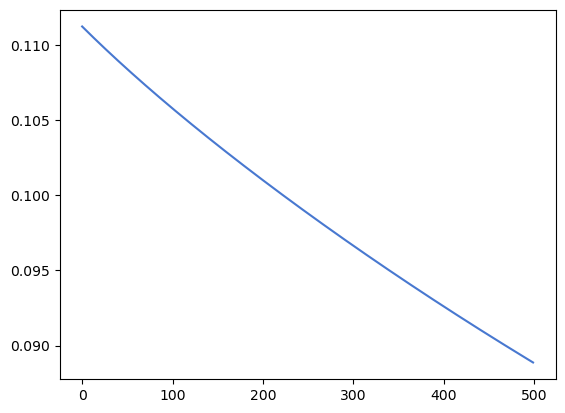

In [2428]:
plt.plot(loss_trace)

loss_trace

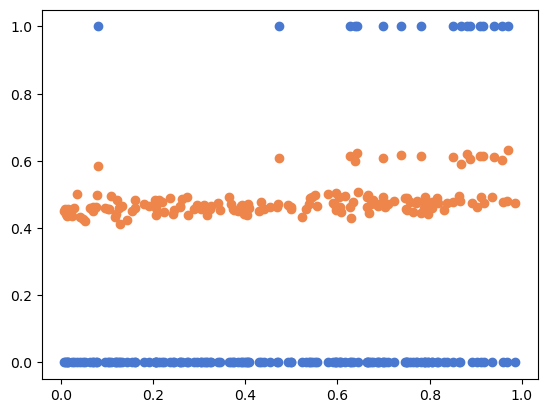

In [2429]:
p_hat = lr(x_test)
y_hat = (p_hat > 0.5).int()

p_hat_train = lr(x_train)
y_hat_train = (p_hat > 0.5).int()


plt.scatter(x_test[:,0], y_test, label = 'Obs')
plt.scatter(x_test[:,0], p_hat.detach()[:,0], label = 'pred prob')

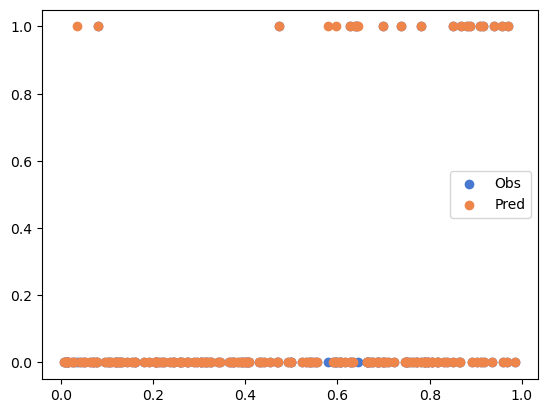

In [2430]:
plt.scatter(x_test[:,0], y_test, label = 'Obs')
plt.scatter(x_test[:,0],y_hat, label = 'Pred')
plt.legend()

In [2431]:
# test accuracy
correct = 0
is_zero = 0
for i in zip(y_test.flatten(), y_hat.flatten()):
    if(int(i[1]) == 0):
        is_zero += 1
    if(int(i[0])==int(i[1])):
        correct += 1
print(correct/len(y_test))
print(is_zero)
print(len(y_test))

0.9753086419753086
141
162


specificity =  0.9724137931034482
sensitivity =  1.0


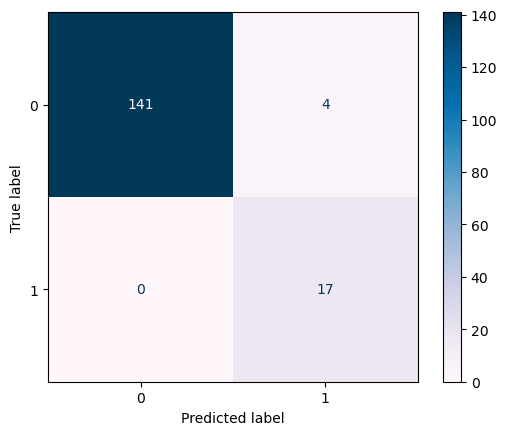

In [2432]:
cm = confusion_matrix(y_test.flatten(), y_hat.flatten())
ConfusionMatrixDisplay(cm).plot(cmap="PuBu")


print("specificity = ", cm[0,0]/(cm[0,0]+cm[0,1]))
print("sensitivity = ", cm[1,1]/(cm[1,0]+cm[1,1]))


Now we have good sensitivity!

In [2433]:
w1 = np.linspace(0,1,25)
w0 = (1-w1)
for n, i in enumerate(w1):
    lr = LogisticRegression(x_train, y_train)

#adjusted iterations until the model didn't seem overfit

    loss_trace = np.zeros(500)
    print(w1[n], w0[n])

    #I've hand-fine-tuned the learning rate to get the best loss

    for i in trange(500):
        loss = weighted_bce_loss(lr, x_train, y_train, w1[n], w0[n])

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-2 * lr.beta.grad
    
        lr.beta.grad.zero_()

    p_hat = lr(x_test)
    y_hat = (p_hat > 0.5).int()
    cm = confusion_matrix(y_test.flatten(), y_hat.flatten())
    print("specificity = ", cm[0,0]/(cm[0,0]+cm[0,1]))
    print("sensitivity = ", cm[1,1]/(cm[1,0]+cm[1,1]))
    


import gc

del X
del y_test
del x_train
del x_test
del y_train
del climate
del cancer
gc.collect()

0.0 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.041666666666666664 0.9583333333333334


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.08333333333333333 0.9166666666666666


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.125 0.875


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.16666666666666666 0.8333333333333334


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.20833333333333331 0.7916666666666667


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.25 0.75


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.29166666666666663 0.7083333333333334


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.3333333333333333 0.6666666666666667


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.375 0.625


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.41666666666666663 0.5833333333333334


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.4583333333333333 0.5416666666666667


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.5 0.5


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.5416666666666666 0.45833333333333337


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.5833333333333333 0.41666666666666674


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.625 0.375


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.6666666666666666 0.33333333333333337


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.7083333333333333 0.29166666666666674


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.75 0.25


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.7916666666666666 0.20833333333333337


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.0
0.8333333333333333 0.16666666666666674


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  0.11764705882352941
0.875 0.125


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  1.0
sensitivity =  1.0
0.9166666666666666 0.08333333333333337


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  0.8344827586206897
sensitivity =  1.0
0.9583333333333333 0.04166666666666674


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  0.0
sensitivity =  1.0
1.0 0.0


  0%|          | 0/500 [00:00<?, ?it/s]

specificity =  0.0
sensitivity =  1.0


106410

We can see that this confirms that our original weight strategy was sufficiently optimal. The sensitivity and specificity is maximized almost exactly where our original pair is. 0.875 0.125 seems to be a little better, though, but our method is sufficient!

In [2434]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from sklearn.model_selection import train_test_split


np.random.seed(0)

# random features (100 observations, 400 feeatures)
x = np.random.normal(0, 1, [200, 400])

# only 5 features are relevant (non-zero coefficient)
beta = np.concatenate([2 * np.ones(5), np.zeros(395)]).reshape(-1, 1)

# outcome variable
y = x @ beta + 0.1 * np.random.normal(0, 1, [200, 1])

print(y)

[[ 14.55995525]
 [ -4.63126159]
 [  5.33977593]
 [ -3.56333021]
 [ -6.07293602]
 [ -8.38661518]
 [  2.00751836]
 [ -3.46761532]
 [-11.61994625]
 [ -1.21586062]
 [  4.33091611]
 [ -2.69536817]
 [  1.99663237]
 [ -6.59715766]
 [  5.37883363]
 [  4.76856703]
 [  1.86774892]
 [ -1.57828034]
 [  3.00515663]
 [  5.25281535]
 [  3.55292025]
 [ -4.4617397 ]
 [ -0.91654699]
 [  7.63143883]
 [  2.68419004]
 [  1.40817516]
 [ -2.25976923]
 [ -1.30309865]
 [  0.57636659]
 [  4.77664065]
 [  1.85368439]
 [ -2.11214343]
 [  1.19182173]
 [ -2.3867429 ]
 [  5.34901356]
 [  5.51017065]
 [ -9.7333425 ]
 [ -0.32580566]
 [ -4.26535713]
 [  1.00571687]
 [ -0.77607302]
 [  3.22514179]
 [ -3.80473373]
 [ -2.58021704]
 [  6.56992352]
 [  1.25074237]
 [ -5.52930274]
 [  0.12407608]
 [ -2.63703466]
 [ -2.78003252]
 [ -1.77612772]
 [ -0.72718929]
 [-11.23065294]
 [ -4.59846624]
 [  0.78634778]
 [ -3.67455265]
 [ -6.73619199]
 [ -3.96450308]
 [  4.11248553]
 [ -8.63356455]
 [ -0.91899738]
 [ -3.24354503]
 [  0.72

In [2435]:
def mse_ridge(model, x, y, lam):
  p = model(x)
  return torch.mean((y-p)**2)+lam*torch.mean((model.beta)**2)
def mse(model, x, y):
  p = model(x)
  return torch.mean((y-p)**2)

In [2436]:
#we need to split the data:


#clearing the memory so my laptop doesn't crash.

x = torch.tensor(x)
y = torch.tensor(y).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [2437]:
mse_r = []
rsq_r = []

original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

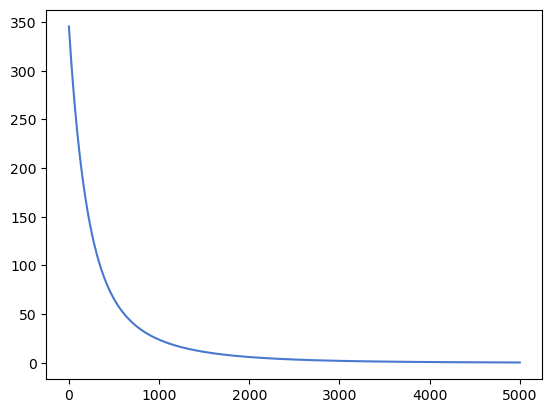

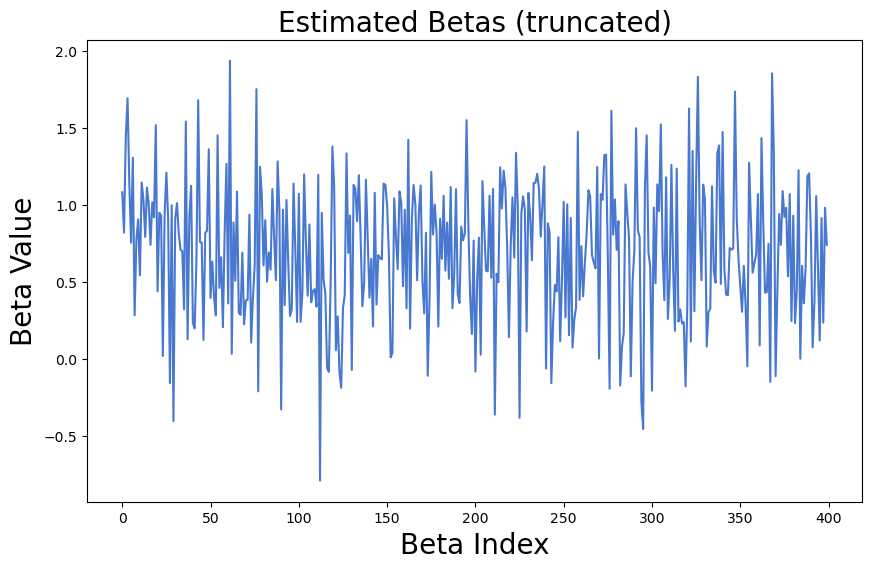

356.17761779493685
torch.Size([60, 1]) torch.Size([60, 1])


In [2438]:
# trying w/ mse
loss_trace = np.zeros(5000)
from torchmetrics import R2Score
from torchmetrics import MeanSquaredError

mserr = MeanSquaredError()
rsq = R2Score()


lr = LinearRegression(x_train, y_train)
print("original mse",int(mse(lr,x_test,y_test)))

for i in trange(5000):
        loss = mse_ridge(lr, x_train, y_train,0)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)
plt.plot(loss_trace)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()
print((float(mse(lr,x_test,y_test))))
print(y_test.shape, p_hat.shape)
mse_r.append(float(mse(lr,x_test,y_test)))



original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

tensor(346.8674, grad_fn=<SqueezeBackward0>)


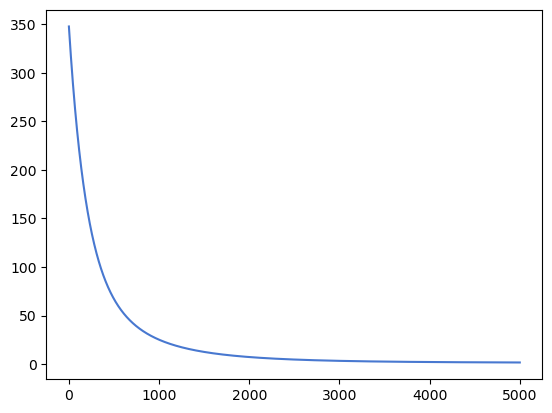

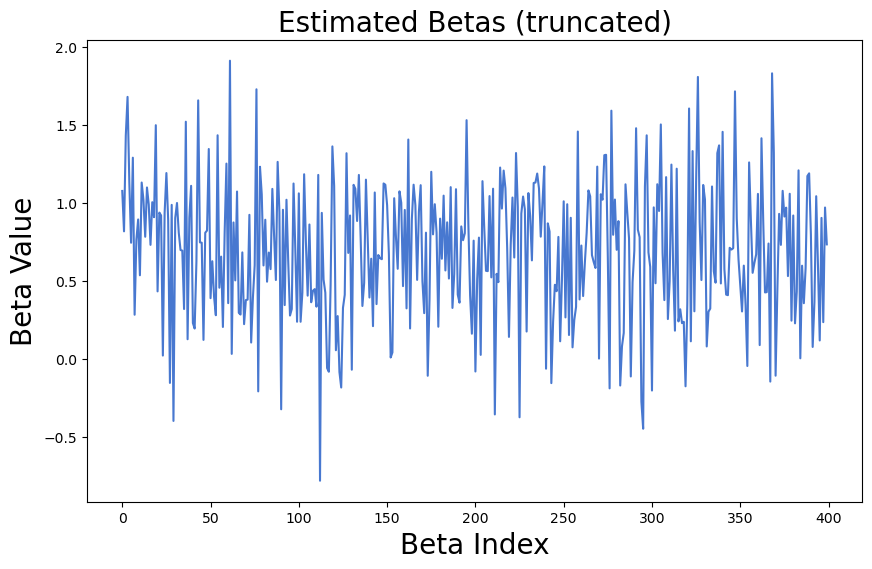

tensor(-14.8397, grad_fn=<SqueezeBackward0>)


In [2439]:
#same as mse
loss_trace = np.zeros(5000)

lr = LinearRegression(x_train, y_train)

print("original mse",int(mse(lr,x_test,y_test)))

for i in trange(5000):
        loss = mse_ridge(lr, x_train, y_train,2)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)

print(mserr(p_hat,y_test))


plt.plot(loss_trace)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

mse_r.append(float(mse(lr,x_test,y_test)))
print(rsq(p_hat,y_test))
rsq_r.append(float(rsq(p_hat,y_test)))




original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

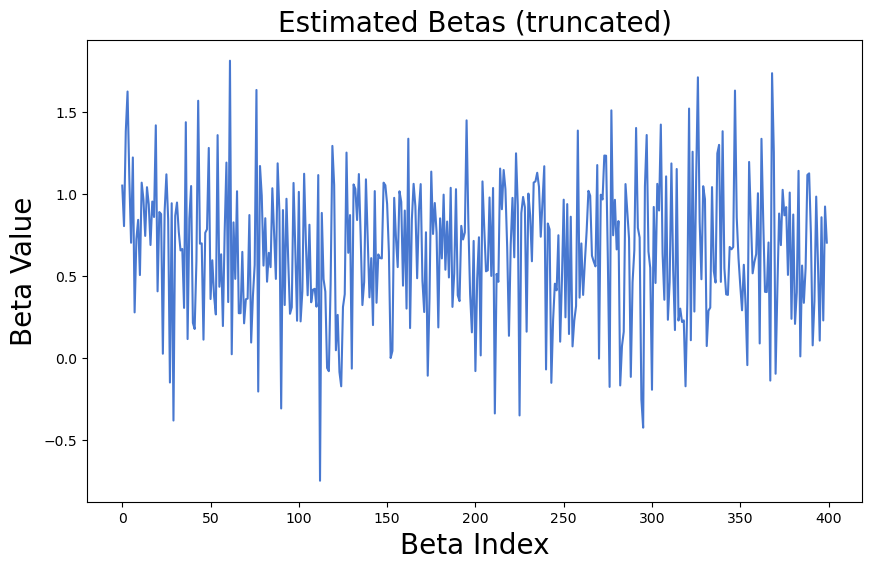

tensor(-13.2509, grad_fn=<SqueezeBackward0>)


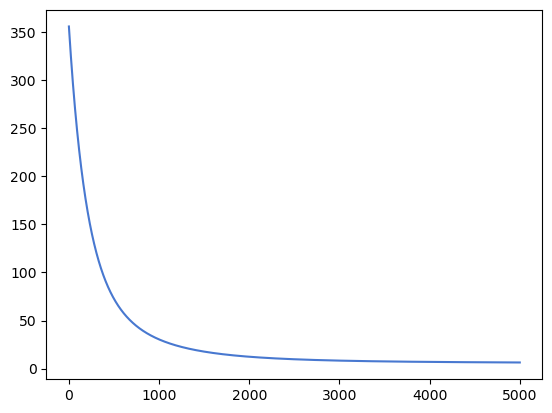

In [2440]:
lr = LinearRegression(x_train, y_train)

print("original mse",int(mse(lr,x_test,y_test)))

loss_trace = np.zeros(5000)

for i in trange(5000):
        loss = mse_ridge(lr, x_train, y_train,10)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

plt.plot(loss_trace)

mse_r.append(float(mse(lr,x_test,y_test)))

print(rsq(p_hat,y_test))
rsq_r.append(float(rsq(p_hat,y_test)))



original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

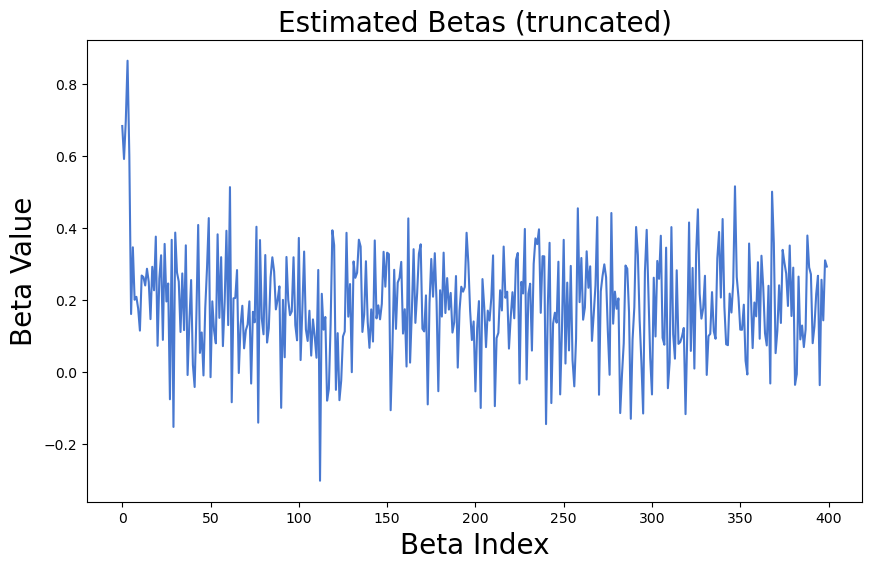

tensor(-0.6245, grad_fn=<SqueezeBackward0>)


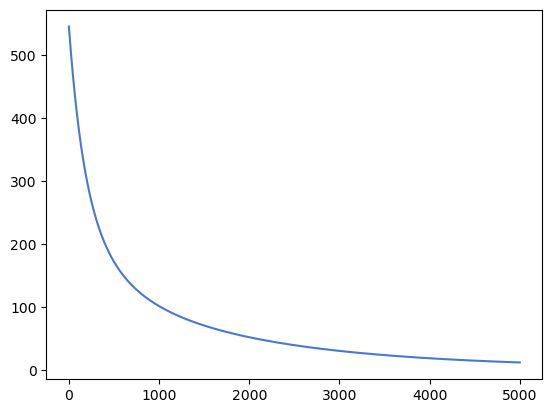

In [2441]:
lr = LinearRegression(x_train, y_train)

print("original mse",int(mse(lr,x_test,y_test)))

loss_trace = np.zeros(5000)

for i in trange(5000):
        loss = mse_ridge(lr, x_train, y_train,200)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

plt.plot(loss_trace)

mse_r.append(float(mse(lr,x_test,y_test)))
print(rsq(p_hat,y_test))
rsq_r.append(float(rsq(p_hat,y_test)))


original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

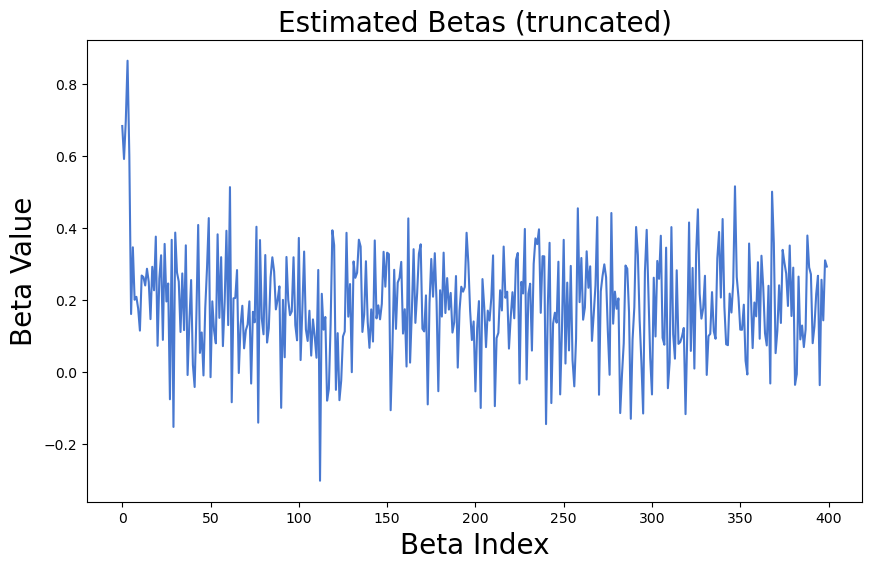

tensor(-0.6245, grad_fn=<SqueezeBackward0>)


  0%|          | 0/5000 [00:00<?, ?it/s]

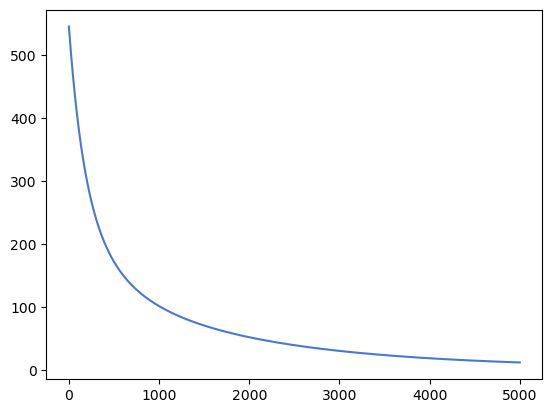

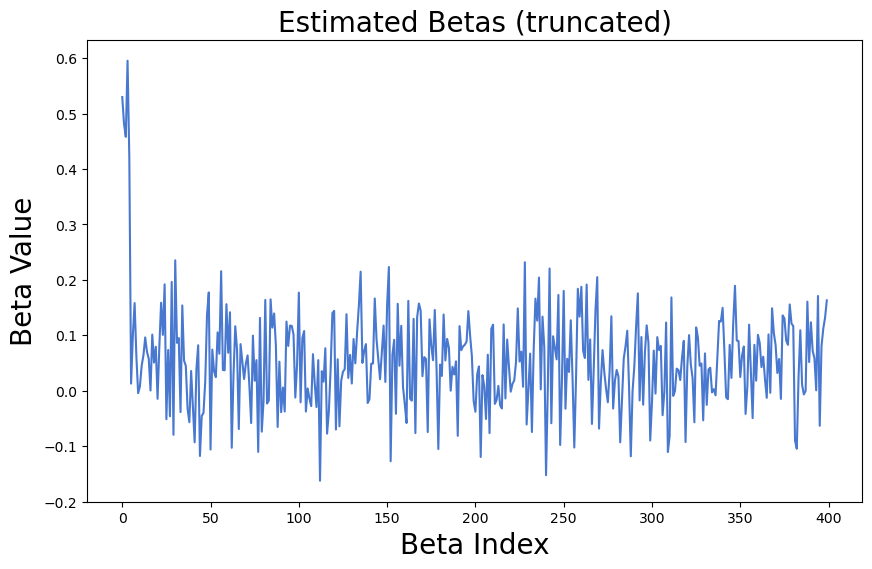

tensor(0.2110, grad_fn=<SqueezeBackward0>)


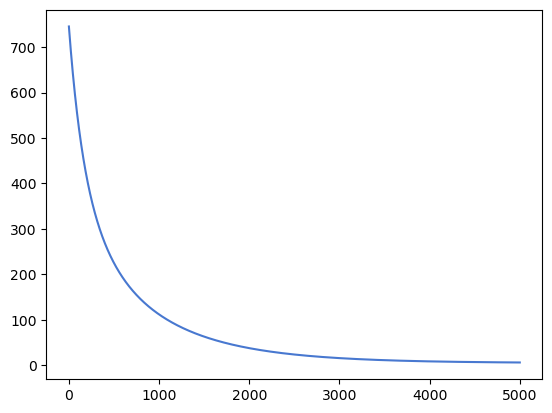

In [2442]:
lr = LinearRegression(x_train, y_train)

print("original mse",int(mse(lr,x_test,y_test)))

loss_trace = np.zeros(5000)

for i in trange(5000):
        loss = mse_ridge(lr, x_train, y_train,200)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)
y_hat = (p_hat > 0.5).int()

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

print(rsq(p_hat,y_test))
rsq_r.append(int(rsq(p_hat,y_test)))

plt.plot(loss_trace)

lr = LinearRegression(x_train, y_train)
loss_trace = np.zeros(5000)


for i in trange(5000):
        loss = mse_ridge(lr, x_train, y_train,400)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

plt.plot(loss_trace)

mse_r.append(float(mse(lr,x_test,y_test)))
print(rsq(p_hat,y_test))
rsq_r.append(float(rsq(p_hat,y_test)))



original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

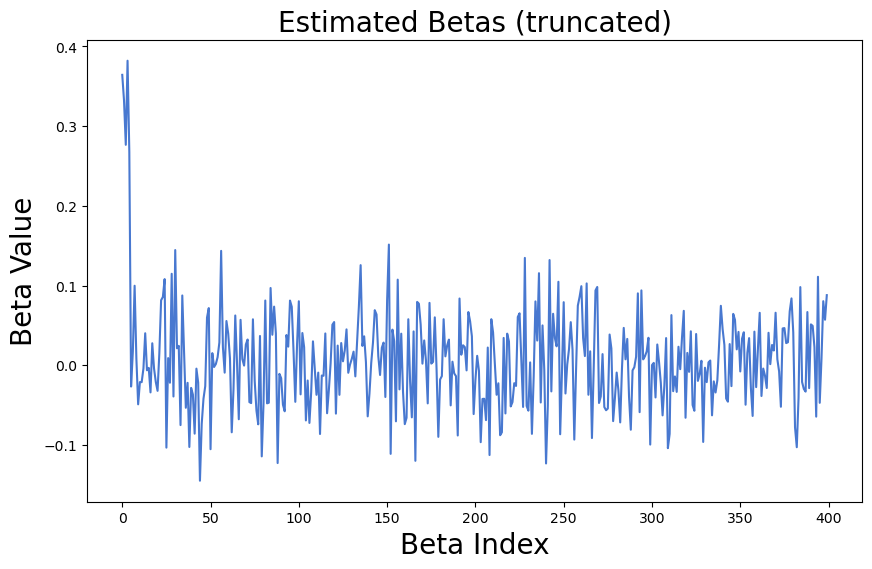

tensor(0.1707, grad_fn=<SqueezeBackward0>)


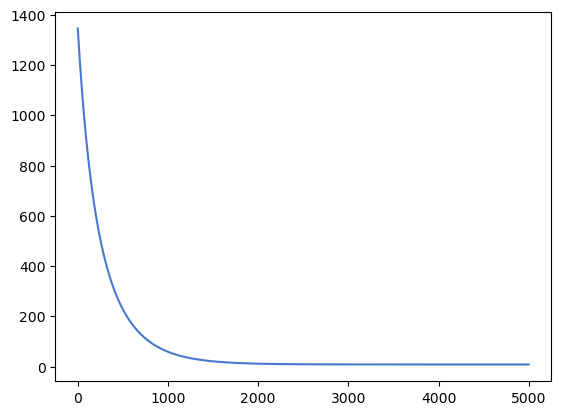

In [2443]:
lr = LinearRegression(x_train, y_train)

print("original mse",int(mse(lr,x_test,y_test)))

loss_trace = np.zeros(5000)

for i in trange(5000):
        loss = mse_ridge(lr, x_train, y_train,1000)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

plt.plot(loss_trace)



print(rsq(p_hat,y_test))
mse_r.append(float(mse(lr,x_test,y_test)))
rsq_r.append(float(rsq(p_hat,y_test)))

In [2444]:
print(mse_r)
print(rsq_r)

ridge_mse = mse_r.copy()
ridge_r2 = rsq_r.copy()

mse_r.clear()
rsq_r.clear()

print(ridge_mse)

[356.17761779493685, 346.8673714292788, 312.0736625244574, 35.57434481786101, 17.277743115725762, 18.160487433555122]
[-14.839720726013184, -13.250863075256348, -0.6245046854019165, 0, 0.21101081371307373, 0.17070019245147705]
[356.17761779493685, 346.8673714292788, 312.0736625244574, 35.57434481786101, 17.277743115725762, 18.160487433555122]


We see as we increase lambda, the true parameters of beta become more distinguished, while the insignificant values tend to zero. This method is very noisy, though. From here, I'd imagine if I was a researcher, I would seperate the seemingly insignificant terms and try to make a better model. We notice that the best value for lambda lies around 400.

In [2445]:
# write some code here

In [2446]:
mse_r = []
rsq_r = []

In [2447]:
# write some code here

def mse_lasso(model, x, y, lam):
  p = model(x)
  return torch.mean((y-p)**2)+lam*torch.mean(torch.abs(model.beta))



original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

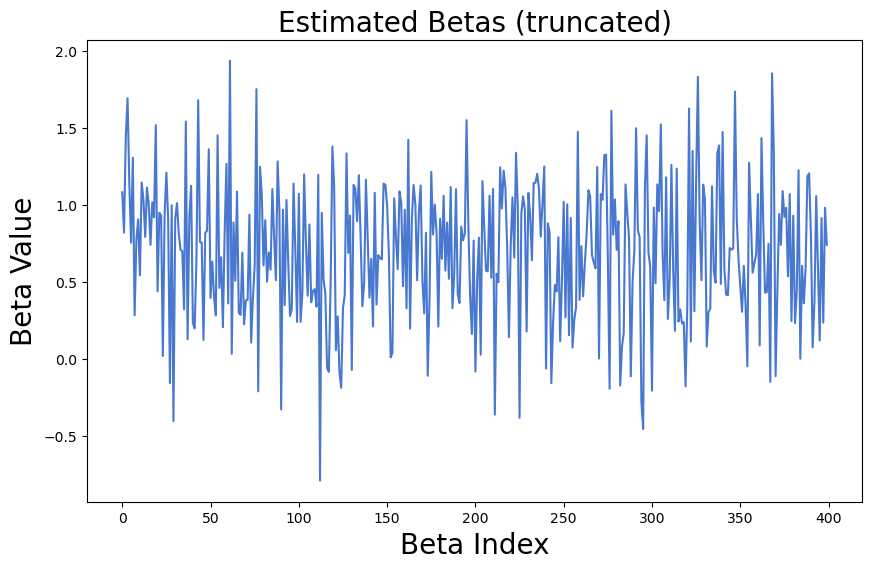

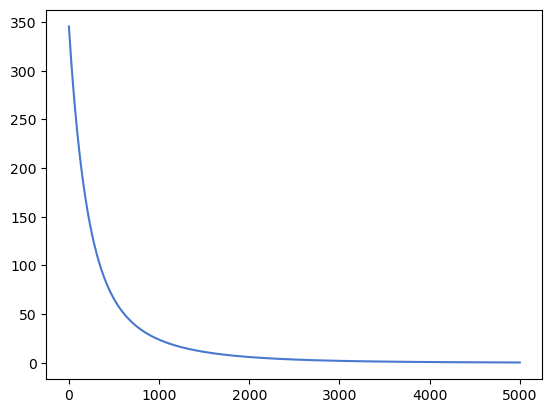

In [2448]:
lr = LinearRegression(x_train, y_train)
loss_trace = np.zeros(5000)

print("original mse",int(mse(lr,x_test,y_test)))


for i in trange(5000):
        loss = mse_lasso(lr, x_train, y_train,0)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

plt.plot(loss_trace)

mse_r.append(float(mse(lr,x_test,y_test)))
rsq_r.append(float(rsq(p_hat,y_test)))

original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

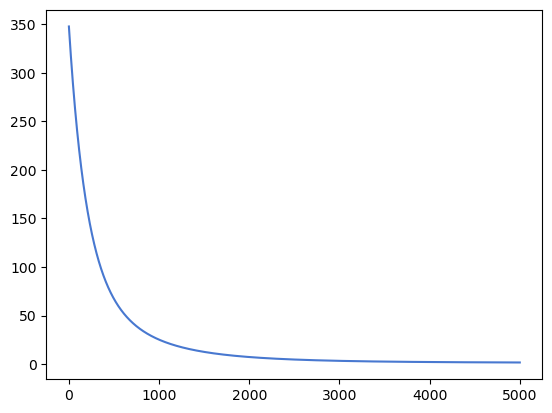

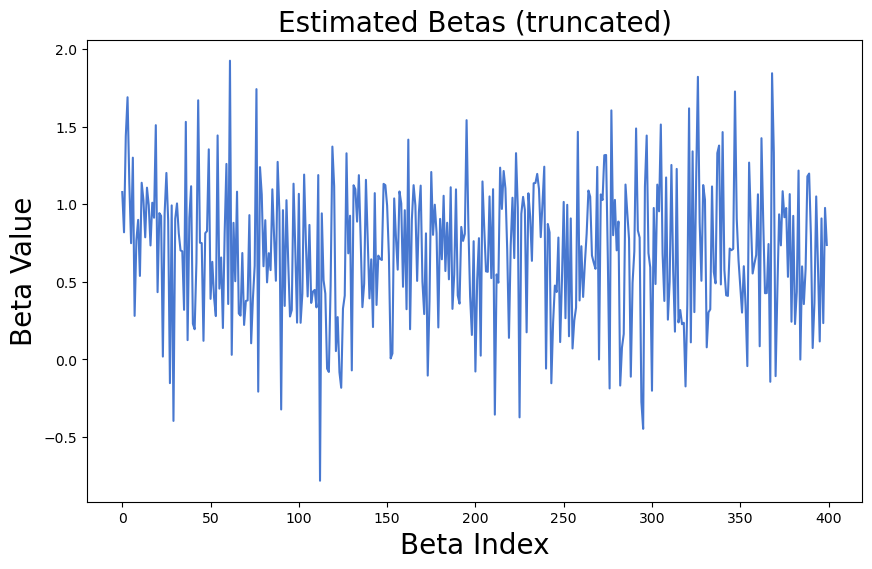

In [2449]:
lr = LinearRegression(x_train, y_train)
loss_trace = np.zeros(5000)

print("original mse",int(mse(lr,x_test,y_test)))

for i in trange(5000):
        loss = mse_lasso(lr, x_train, y_train,2)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)
plt.plot(loss_trace)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

mse_r.append(float(mse(lr,x_test,y_test)))
rsq_r.append(float(rsq(p_hat,y_test)))

original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

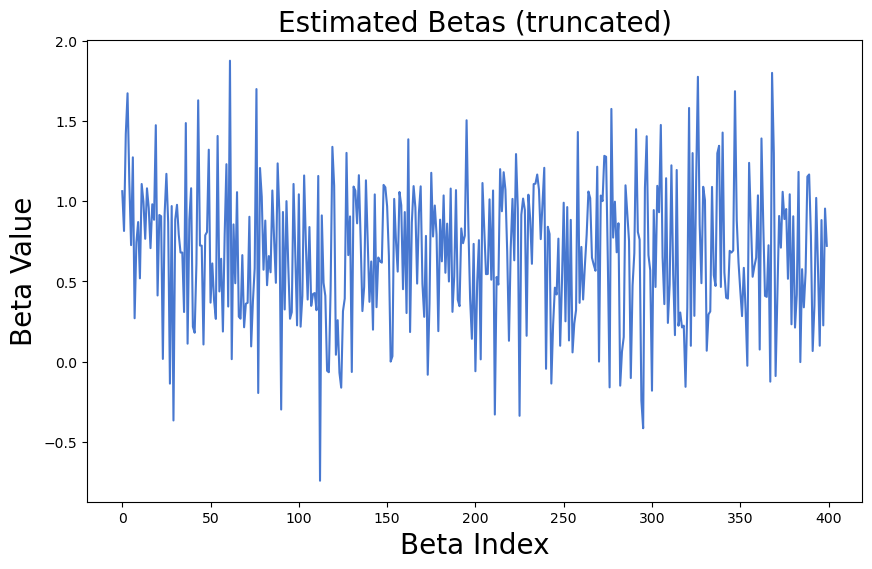

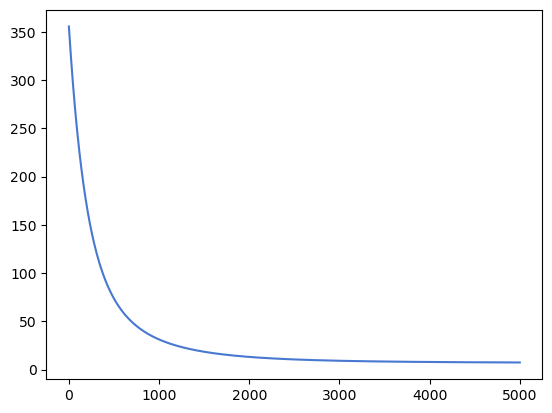

In [2450]:
lr = LinearRegression(x_train, y_train)
loss_trace = np.zeros(5000)

print("original mse",int(mse(lr,x_test,y_test)))


for i in trange(5000):
        loss = mse_lasso(lr, x_train, y_train,10)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

plt.plot(loss_trace)

mse_r.append(float(mse(lr,x_test,y_test)))
rsq_r.append(float(rsq(p_hat,y_test)))

original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

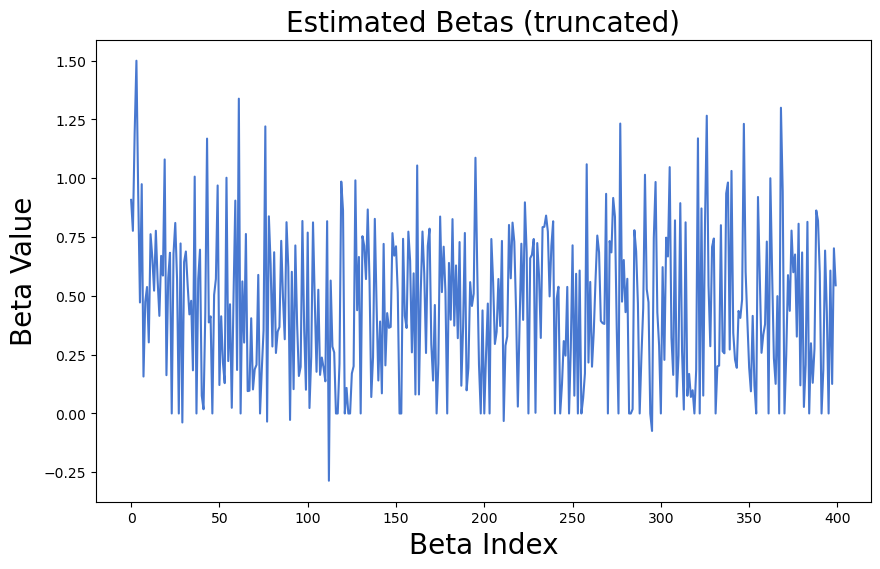

162


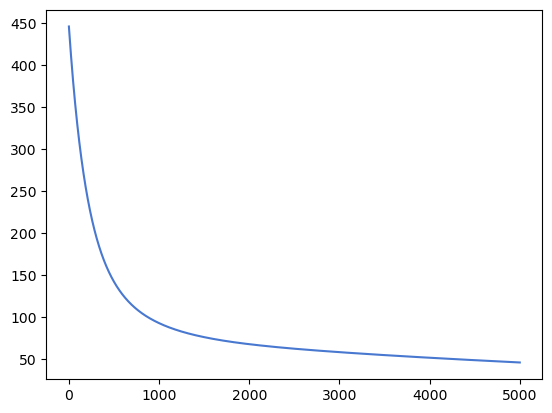

In [2451]:
lr = LinearRegression(x_train, y_train)
loss_trace = np.zeros(5000)

print("original mse",int(mse(lr,x_test,y_test)))

for i in trange(5000):
        loss = mse_lasso(lr, x_train, y_train,100)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

print(int(mse(lr,x_test,y_test)))

plt.plot(loss_trace)

mse_r.append(float(mse(lr,x_test,y_test)))
rsq_r.append(float(rsq(p_hat,y_test)))

original mse 370


  0%|          | 0/5000 [00:00<?, ?it/s]

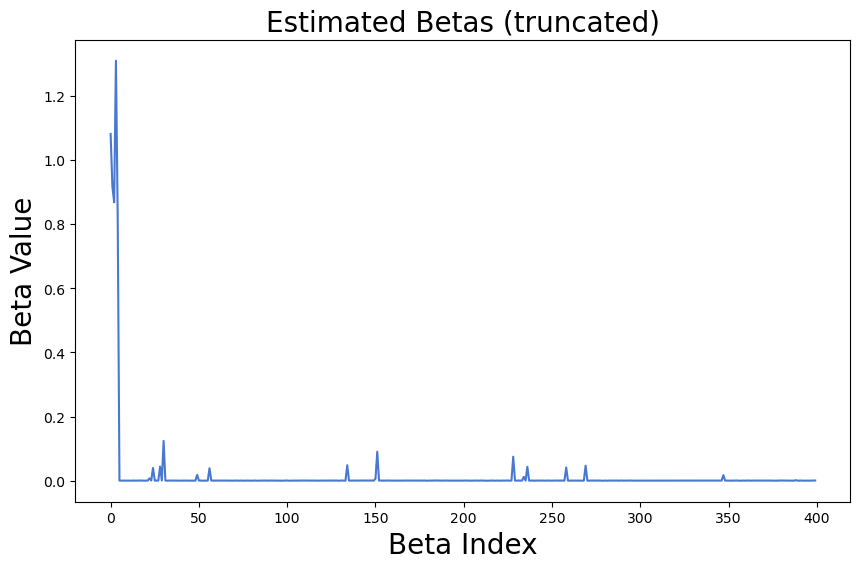

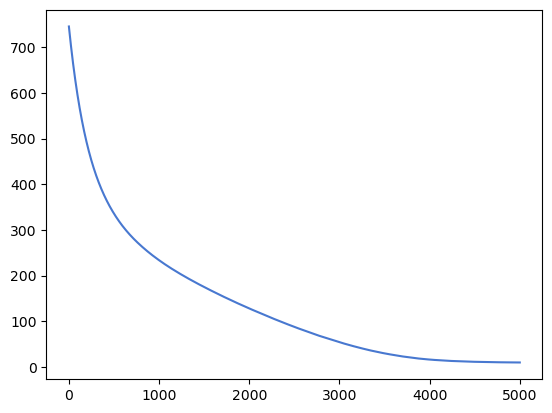

In [2452]:
lr = LinearRegression(x_train, y_train)
loss_trace = np.zeros(5000)

print("original mse",int(mse(lr,x_test,y_test)))


for i in trange(5000):
        loss = mse_lasso(lr, x_train, y_train,400)

        loss_trace[i] = loss

        loss.backward()
        lr.beta.data = lr.beta.data - 2.7e-4 * lr.beta.grad
    
        lr.beta.grad.zero_()

p_hat = lr(x_test)

plt.figure(figsize = (10, 6))
plt.plot(lr.beta[0:].detach())
plt.xlabel('Beta Index', fontsize = 20)
plt.ylabel('Beta Value', fontsize = 20)
plt.title('Estimated Betas (truncated)', fontsize = 20)
plt.show()

plt.plot(loss_trace)

mse_r.append(float(mse(lr,x_test,y_test)))
rsq_r.append(float(rsq(p_hat,y_test)))

We see that as we increase lambda in both cases, the values of beta that are insignificant tend towards zero, whereas the values that are actually significant become more defined.

In [2453]:
lasso_rsq = rsq_r
lasso_mse = mse_r

First, let's compare the MSE values of ridge and lasso regression:

In [2454]:
print(ridge_mse)
print(lasso_mse)

[356.17761779493685, 346.8673714292788, 312.0736625244574, 35.57434481786101, 17.277743115725762, 18.160487433555122]
[356.17761779493685, 351.4216817189395, 332.71991954806015, 162.11108541426157, 6.312028660927748]


Now let's look at $R^2$

In [2459]:
print(ridge_r2)
print(lasso_rsq)

[-14.839720726013184, -13.250863075256348, -0.6245046854019165, 0, 0.21101081371307373, 0.17070019245147705]
[-15.264871597290039, -15.047693252563477, -14.193675994873047, -6.402812480926514, 0.7117608189582825]


Lasso clearly and undoubtedly outperformed ridge in this case. The $R^2$ for ridge is simply unacceptable. Lasso is not amazing, but it is a lot better. None of the provided values for lambda are acceptable, either. 400 seems like a good value for lambda for both, but again, LASSO penalty is best.

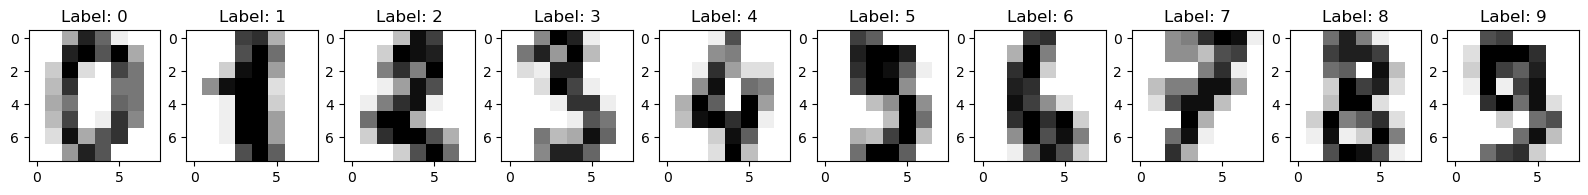

In [2492]:
from sklearn import datasets
digits = datasets.load_digits()

x, y = digits.data, digits.target

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, label in zip(axes, x, y):
    ax.imshow(image.reshape(8, 8), cmap=plt.cm.gray_r)
    ax.set_title("Label: %i" % label)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

y = y.reshape(-1, 1)
y_enc = OneHotEncoder().fit_transform(y).toarray()

x_train, x_test, y_train, y_test = train_test_split(x, y_enc, test_size=0.25, random_state=0)

x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)


In [2489]:
def softmax(z):
  return torch.exp(z)/(torch.sum(torch.exp(z)))

Text(0.5, 1.0, 'Softmax Z')

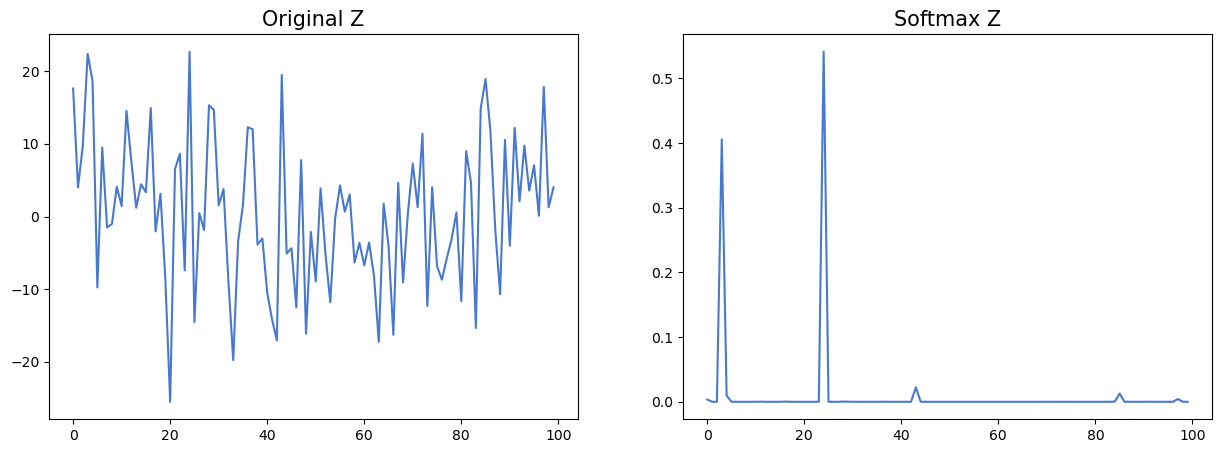

In [2491]:
np.random.seed(0)
z = np.random.normal(0, 10, 100)
z = torch.tensor(z)

fig, ax = plt.subplots(1, 2,  figsize = (15, 5))
ax[0].plot(z)
ax[0].set_title("Original Z", fontsize = 15)

ax[1].plot(softmax(z))
ax[1].set_title("Softmax Z", fontsize = 15)


### part 2 - Implement the model

Now lets create a class called `MultiLogisticRegression`. This class should do the following

1. Automatically determine the shapes of $\beta$ and $\alpha$ from the data `x` and `y`
2. Initialize $\alpha$ and $\beta$ and enable gradient tracking
3. Include a `forward()` function that computes class probabilities given input `x`
4. Include a `classify()` function that classifies inputs `x`, i.e. return the class with the highest probability.

Below we have provided a starter class that inherits from `nn.Module`.

To make sure its working. Instantiate your class and call the forward function on `x_train`. Print the output (it should be a tensor of all $0.1$)



In [2565]:
## numerical minimization
import torch
import torch.nn as nn



class MultiLogisticRegression(nn.Module):
    def __init__(self, x, y):
      super(MultiLogisticRegression, self).__init__()
      self.beta = torch.zeros(x.shape[1]).double().reshape(-1, 1)
      self.alpha = torch.zeros(1).double().reshape(-1, 1)

      self.beta.requires_grad_()
      self.alpha.requires_grad_()
      
    def forward(self, x):
      #basically 3D sigmoid(t)
      t = x @ self.beta+self.alpha      
      return torch.softmax(t, axis = 1) # computes softmax of each row

    def classify(self, x):
      #takes an image and yields an answer
      0

In [2566]:
model = MultiLogisticRegression(x_train, y_train)
model(x_train)


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

answer goes here

### Part 3 - Loss function

1. Write a function `multi_bce()` that computes the multi-target BCE loss. 

2. Print the loss of your untrained model on the training dataset (should be around $0.3251$)


In [2559]:
def multi_bce(model, x, y):
  p = model(x)
  return -torch.sum(y*torch.log(p))

In [2560]:
multi_bce(model,x_train,y_train)

tensor(-0., dtype=torch.float64, grad_fn=<NegBackward0>)

### Part 4 - Training

1. Train a multi-target logisitc regression on the digits dataset to classify images of digits. Use the model you just constructed. Write your own gradient descent loop.

2. Plot the loss trace (did it converge?) and print the test __accuracy__. The test __accuracy__ needs to be above 0.95. 